In [1]:
%pip install numpy
%pip install transformers
%pip install tensorflow

     |████████████████████████████████| 3.5 MB 4.5 MB/s 
     |████████████████████████████████| 6.8 MB 33.8 MB/s 
     |████████████████████████████████| 596 kB 30.7 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 462 kB 5.4 MB/s 


In [2]:

import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from google.colab import drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [4]:
# set environment as googledrive to folder "resource"
from google.colab import drive

data_path =  "/MultiDomainDataset/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/MyDrive/MultiDomainDataset/"

except:
    print("You are not working in Colab at the moment :(")

Mounted at /content/drive


In [5]:
col_names = ["index","text","intent"]
df_train = pd.read_csv("drive/MyDrive/MultiDomainDataset/domain_train.csv",names=col_names, header=None)
df_train

,index,text,intent
0,NaN,text,intent
1,0.0,i want to fly from baltimore to dallas round trip,1
2,1.0,round trip fares from baltimore to philadelphi...,1
3,2.0,show me the flights arriving on baltimore on j...,1
4,3.0,what are the flights which depart from san fra...,1
...,...,...,...
33207,33206.0,Where is the profile section,3
33208,33207.0,Wheres my profile,3
33209,33208.0,show my profile,3
33210,33209.0,How can I update my information if I dont know...,3


In [6]:
col_names = ["index","text","intent"]
df_train = pd.read_csv("drive/MyDrive/MultiDomainDataset/domain_train.csv",names=col_names, header=None)
df_train = df_train.iloc[1:]
df_train["intent"] = LabelEncoder().fit_transform(df_train["intent"])
df_train = df_train.reset_index(drop=True)
del df_train["index"]
df_train



,text,intent
0,i want to fly from baltimore to dallas round trip,0
1,round trip fares from baltimore to philadelphi...,0
2,show me the flights arriving on baltimore on j...,0
3,what are the flights which depart from san fra...,0
4,which airlines fly from boston to washington d...,0
...,...,...
33206,Where is the profile section,2
33207,Wheres my profile,2
33208,show my profile,2
33209,How can I update my information if I dont know...,2


In [27]:
col_names = ["index","text","intent"]
df_test = pd.read_csv("drive/MyDrive/MultiDomainDataset/domain_test.csv",names=col_names, header=None)
df_test = df_test.iloc[1:]
df_test["intent"] = LabelEncoder().fit_transform(df_test["intent"])
df_test = df_test.reset_index(drop=True)
del df_test["index"]
df_test

,text,intent
0,i would like to find a flight from charlotte t...,0
1,on april first i need a ticket from tacoma to ...,0
2,on april first i need a flight going from phoe...,0
3,i would like a flight traveling one way from p...,0
4,i would like a flight from orlando to salt lak...,0
...,...,...
21010,I want to view my profile,2
21011,Where is my profile section,2
21012,Where can I find the profile section in My Acc...,2
21013,Where is my profile section located,2


In [28]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_test = shuffle(df_test)

In [29]:
train_texts = df_train["text"]
train_labels= df_train["intent"]

test_texts = df_test["text"]
test_labels= df_test["intent"]


In [30]:
df_test["intent"][1]


0

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentences = train_texts
max_len = 20


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
input_ids = []
attention_masks = []

for text in train_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

print('Original: ', train_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  i want to fly from baltimore to dallas round trip
Token IDs: tensor([ 101, 1045, 2215, 2070, 4469, 3558, 5329, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [14]:

train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(set(train_labels))

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)



/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Batch    10  of  1,038.    Elapsed: 0:00:03.
Batch    20  of  1,038.    Elapsed: 0:00:06.
Batch    30  of  1,038.    Elapsed: 0:00:09.
Batch    40  of  1,038.    Elapsed: 0:00:11.
Batch    50  of  1,038.    Elapsed: 0:00:14.
Batch    60  of  1,038.    Elapsed: 0:00:17.
Batch    70  of  1,038.    Elapsed: 0:00:20.
Batch    80  of  1,038.    Elapsed: 0:00:23.
Batch    90  of  1,038.    Elapsed: 0:00:26.
Batch   100  of  1,038.    Elapsed: 0:00:29.
Batch   110  of  1,038.    Elapsed: 0:00:32.
Batch   120  of  1,038.    Elapsed: 0:00:35.
Batch   130  of  1,038.    Elapsed: 0:00:38.
Batch   140  of  1,038.    Elapsed: 0:00:41.
Batch   150  of  1,038.    Elapsed: 0:00:44.
Batch   160  of  1,038.    Elapsed: 0:00:47.
Batch   170  of  1,038.    Elapsed: 0:00:50.
Batch   180  of  1,038.    Elapsed: 0:00:53.
Batch   190  of  1,038.    Elapsed: 0:00:55.
Batch   200  of  1,038.    Elapsed: 0:00:58.
Batch   210  of  1,038.    Elapsed: 0:01:01.
Batch   220  of  1,038.  

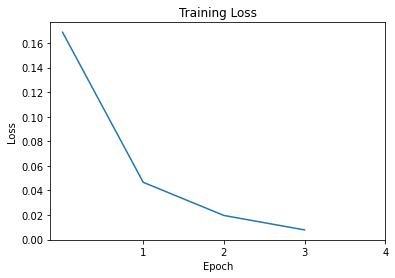

In [17]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [22]:
test_texts = df_test["text"].tolist()
test_texts

['can you order some ointment for me',
 'have new credit card',
 'Im done using this company and dont want my policies any more please cancel',
 'set the ceiling fan to low',
 'I noticed an extra $1 charge on my statement, can you tell me why that is?',
 'Does it take long to change the number cars on my policy',
 'Cant find my proof of insurance card',
 'Can you extend the payment deadline',
 'could you tell me how to direct deposit my check from work into nations bank',
 'Hi John my name is Jessica I have a open claim from  of last year and Ive been trying to reach my adjuster for the Gap portion for a while',
 'I am needing a quote for non owner insurance',
 'Do I need extra coverage for car rentals',
 'how do i cancel online billing',
 'can you check to see if my shopping list already has milk',
 'what is the exchange rate between euros and pesos',
 'I would like to complain about the response time for my agent',
 'what does my insurance policy cover',
 'what is the shipping wait f

In [31]:

test_labels = df_test["intent"].tolist()
test_labels

[2,
 3,
 2,
 2,
 1,
 2,
 2,
 3,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 3,
 0,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 1,
 3,
 3,
 2,
 3,
 2,
 1,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 2,
 0,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 3,
 0,
 1,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 0,
 3,
 2,
 3,
 3,
 3,
 0,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 1,
 3,
 2,
 3,
 2,
 2,
 3,
 1,
 3,
 2,
 2,
 3,
 2,
 3,
 0,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 0,
 2,
 2,
 0,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 0,
 1,
 2,
 3,
 0,
 3,
 2,
 1,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 0,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 3,
 2,
 1,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [32]:
test_texts = df_test["text"].tolist()
test_labels = df_test["intent"].tolist()

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [33]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [34]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)


F-Score:  0.974285840882711
Recall:  0.9767868573053663
Precision:  0.9720651580439236


In [ ]:

train_texts_, train_labels_ = read_atis_split('drive/MyDrive/atis/train')
train_labels_encodded = LabelEncoder().fit_transform(train_labels_)


In [ ]:
dictionary = dict(zip( train_labels_encodded,train_labels_))
print(dictionary)

In [35]:

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

print(report)

                     0            1  ...     macro avg  weighted avg
precision     0.971268     0.966942  ...      0.972065      0.974255
recall        0.994975     0.987662  ...      0.976787      0.974256
f1-score      0.982979     0.977192  ...      0.974286      0.974145
support    1393.000000  3080.000000  ...  21015.000000  21015.000000

[4 rows x 7 columns]
